## Data 3550 Final Project
### Ayman Boules, Katherine Simon, Nicholas Sartino, Sammi Hamdan

# 1. Import the required packages

In [127]:
# Installs (comment out if you don't need)

# !pip install missingno
# !pip install seaborn

In [128]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold




from numpy import arange

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

import statsmodels.api as sm

pd.set_option('display.max_columns',200) #allows for up to 200 columns to be displayed when viewing a dataframe
pd.set_option('display.max_rows',100)
# The following was commented out as it is deprecated and no longer works with current version.
#plt.style.use('seaborn') # a style that can be used for plots - see style reference above

# trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1

## Load in the Dataset

In [147]:
df = pd.read_csv('College_Admission_data.csv')

## Data Exploratory Analysis

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Columns: 108 entries, Name to Endowment assets (year end) per FTE enrollment (FASB)
dtypes: float64(97), object(11)
memory usage: 1.3+ MB


In [131]:
df.describe()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [132]:
df.head()

,Name,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,State abbreviation,FIPS state code,Geographic region,Sector of institution,Level of institution,Control of institution,Historically Black College or University,Tribal college,Degree of urbanization (Urban-centric locale),Carnegie Classification 2010: Basic,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of

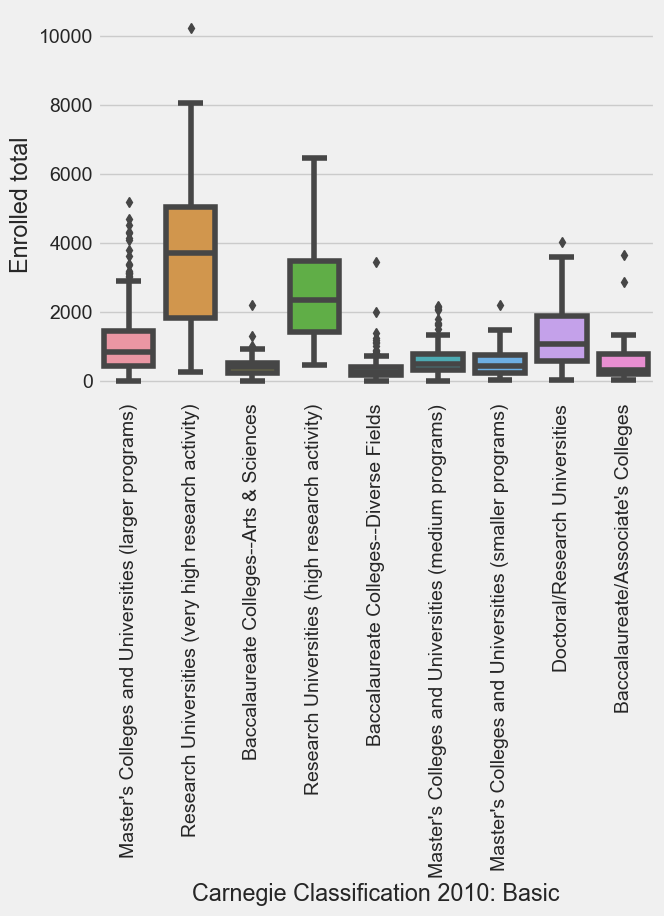

In [133]:
ax = sns.boxplot(x='Carnegie Classification 2010: Basic',y='Enrolled total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

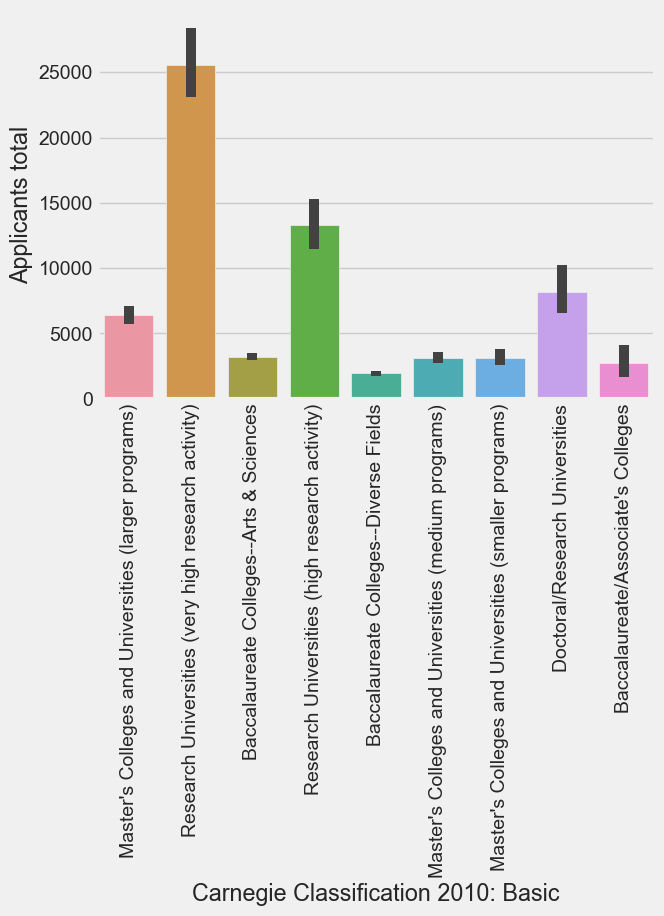

In [134]:
ax = sns.barplot(x='Carnegie Classification 2010: Basic', y='Applicants total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Data Preprocessing

In [148]:
# Splitting the target variable and features
X = df.drop('Carnegie Classification 2010: Basic', axis=1)
y = df['Carnegie Classification 2010: Basic']

In [99]:
# Convert the categorical target variable into a numerical variable.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert the encoded labels back to the original categories
# y = le.inverse_transform(y_encoded)

# Convert categorical features into numerical features.
df_dummies = pd.get_dummies(X, drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Columns: 1735 entries, Applicants total to Degree of urbanization (Urban-centric locale)_Town: Remote
dtypes: bool(1638), float64(97)
memory usage: 3.5 MB


In [100]:
df_dummies.head()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [101]:
# Find columns with missing values and their counts
missing_counts = df_dummies.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Applicants total                                                                           157
Admissions total                                                                           157
Enrolled total                                                                             157
Percent of freshmen submitting SAT scores                                                  277
Percent of freshmen submitting ACT scores                                                  275
SAT Critical Reading 25th percentile score                                                 365
SAT Critical Reading 75th percentile score                                                 365
SAT Math 25th percentile score                                                             352
SAT Math 75th percentile score                                                             352
SAT Writing 25th percentile score                                                          820
SAT Writing 75th percentile score                 

### Data Imputation
* There are a lot of variables with missing values. Many of them are correlated as well. For example, all of the enrollment variables have exactly 2 missing values.
* The goal in this section will be to try to maintain the representation of the data, which means that no statistical value will be used to fill in an NA.

#### Rules that will be followed:
* columns having at least half of its values being missing values will be dropped.
* columns having a significant number of missing values (>=100) will have its values substituted with the median (assuming a normal distribution).
* columns columns having an insignificant number of missing values will be substituted with appropriate values that indicate that those values were not given.

In [102]:
# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)

In [103]:
# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)

/var/folders/q_/tlj94ng165zc5l_0x0clcwg00000gn/T/ipykernel_58968/684822086.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


In [104]:
# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

/var/folders/q_/tlj94ng165zc5l_0x0clcwg00000gn/T/ipykernel_58968/2797988649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.fillna(-1, inplace=True)


In [105]:
# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


In [106]:
df_filtered.head()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 years, total","Graduation rate - Bachelor degree within 6 years, tot

### Train Test Split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded,test_size=0.3,random_state=21)

### Summary of Section
* Categorical variables were converted into numerical variables.
* Missing values were handled according to the rules determined.
* The data was split into training and testing sets.

# Step 2

# Step 3

In [60]:
# Drop 'Name' column from X_train and X_test
X_train = X_train.drop('Name', axis=1)
X_test = X_test.drop('Name', axis=1)

print(X_train.dtypes)
print(X_test.dtypes)

# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# If categorical columns are present, encode them using pd.get_dummies()
if categorical_columns:
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
    
    # Display information about the encoded data
    X_train_encoded.info()
    X_test_encoded.info()

    # Ensure both X_train_encoded and X_test_encoded have the same columns
    common_columns = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))
    X_train_final = X_train_encoded[common_columns]
    X_test_final = X_test_encoded[common_columns]

Applicants total                                         float64
Admissions total                                         float64
Enrolled total                                           float64
Percent of freshmen submitting SAT scores                float64
Percent of freshmen submitting ACT scores                float64
                                                          ...   
Percent of freshmen receiving student loan aid           float64
Percent of freshmen receiving federal student loans      float64
Percent of freshmen receiving other loan aid             float64
Endowment assets (year end) per FTE enrollment (GASB)    float64
Endowment assets (year end) per FTE enrollment (FASB)    float64
Length: 106, dtype: object
Applicants total                                         float64
Admissions total                                         float64
Enrolled total                                           float64
Percent of freshmen submitting SAT scores                float6

In [61]:
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
clf.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Get a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.5228
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.62      0.70        85
           1       0.43      0.80      0.56        75
           2       0.65      0.58      0.61        19
           3       0.05      0.05      0.05        19
           4       0.61      0.51      0.55       120
           5       0.26      0.21      0.23        52
           6       0.11      0.03      0.05        29
           7       0.55      0.62      0.58        34
           8       0.73      0.79      0.76        28

    accuracy                           0.52       461
   macro avg       0.47      0.47      0.46       461
weighted avg       0.53      0.52      0.51       461


In [62]:
# Get feature importances from the trained Decision Tree Classifier
feature_importances = clf.feature_importances_

# Create a DataFrame to associate feature names with their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_final.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
top_n = 10  # Set the number of top features you want to display
top_features = feature_importance_df.head(top_n)
print(top_features)


                                               Feature  Importance
125           Estimated graduate enrollment, full time    0.125254
60                                 Graduate enrollment    0.041246
15          SAT Critical Reading 25th percentile score    0.028803
145  Endowment assets (year end) per FTE enrollment...    0.017189
77                           Tuition and fees, 2011-12    0.016341
66        Percent of freshmen receiving other loan aid    0.011911
159           Estimated graduate enrollment, part time    0.010910
202  Number of first-time undergraduates - foreign ...    0.009530
32           Percent of freshmen receiving Pell grants    0.008485
185         SAT Critical Reading 75th percentile score    0.007642


Based on the code above, the top ten features deamed important by the Decision Tree Classifier are outputted. It shows that among all the features, the "Estimated graduate enrollment, total" is the most significant feature with a importance value of 0.127.  

Estimated graduate enrollment, total: This feature might have high importance because it could be strongly correlated or indicative of certain types of institutions that fall into specific Carnegie classifications. Institutions with higher graduate enrollment might exhibit characteristics associated with certain categories within the classification.  

SAT Critical Reading 25th percentile score: This could indicate the academic profile of students, which might align with the criteria used in the Carnegie classification system to differentiate between different types of institutions.  

Endowment assets per FTE enrollment: Institutions full-time equivalent (FTE) enrollment might belong to a specific category within the Carnegie classification due to financial resources or institutional characteristics associated with these levels of funding.  

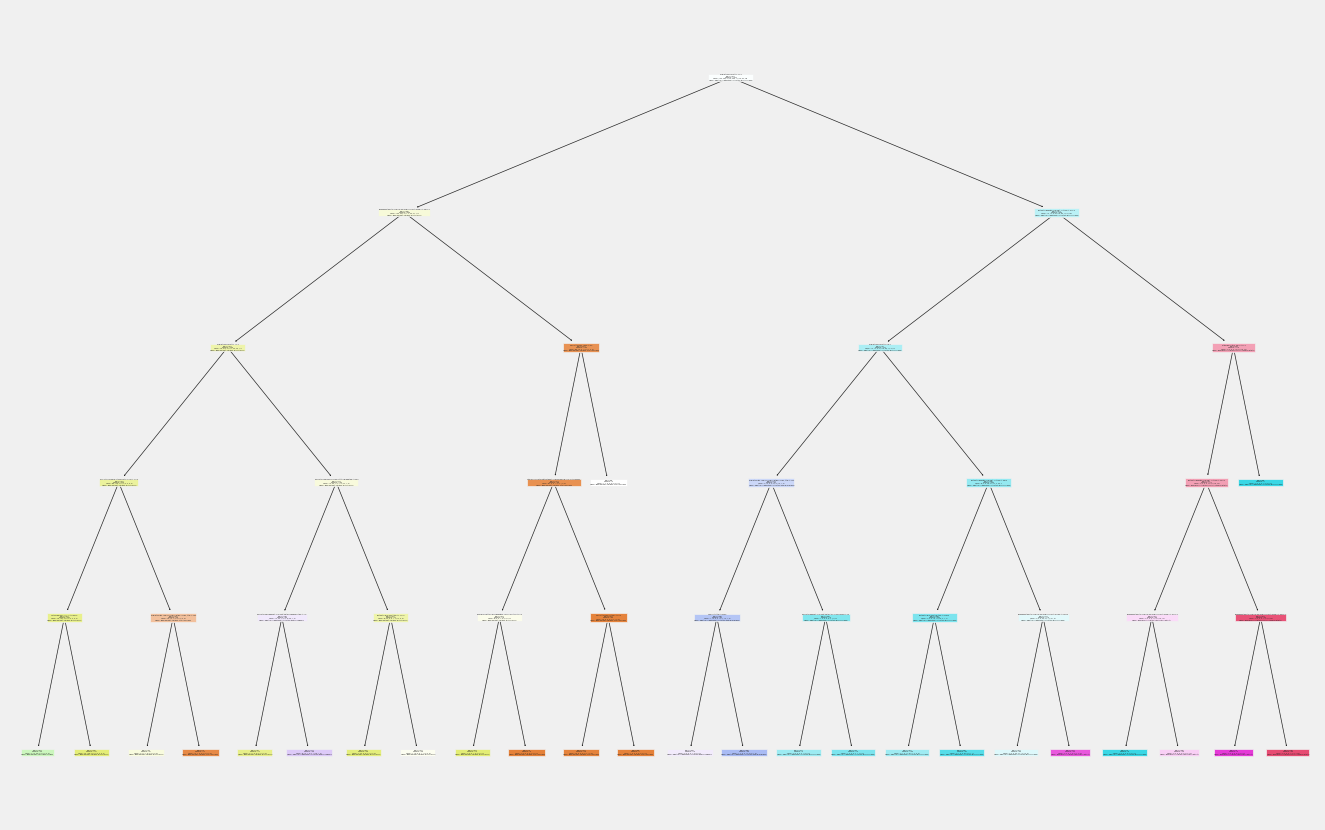

In [63]:
from sklearn.tree import plot_tree


# Fit the Decision Tree Classifier with max_depth=5
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_final, y_train)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=X_train_final.columns.tolist(), class_names=[str(c) for c in le.classes_])
plt.show()



In [64]:
from sklearn.model_selection import GridSearchCV

# Define a range of depths to search through
param_grid = {'max_depth': range(1, 20)}  # Adjust the range as needed

# Create a GridSearchCV object
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_final, y_train)

# Get the best estimator and its parameters
dt_best = grid_search.best_estimator_
best_depth = dt_best.get_params()['max_depth']
print(f"Best tree depth: {best_depth}")

# Fit the best model on the entire training data
dt_best.fit(X_train_final, y_train)


Best tree depth: 5


DecisionTreeClassifier(max_depth=5, random_state=42)

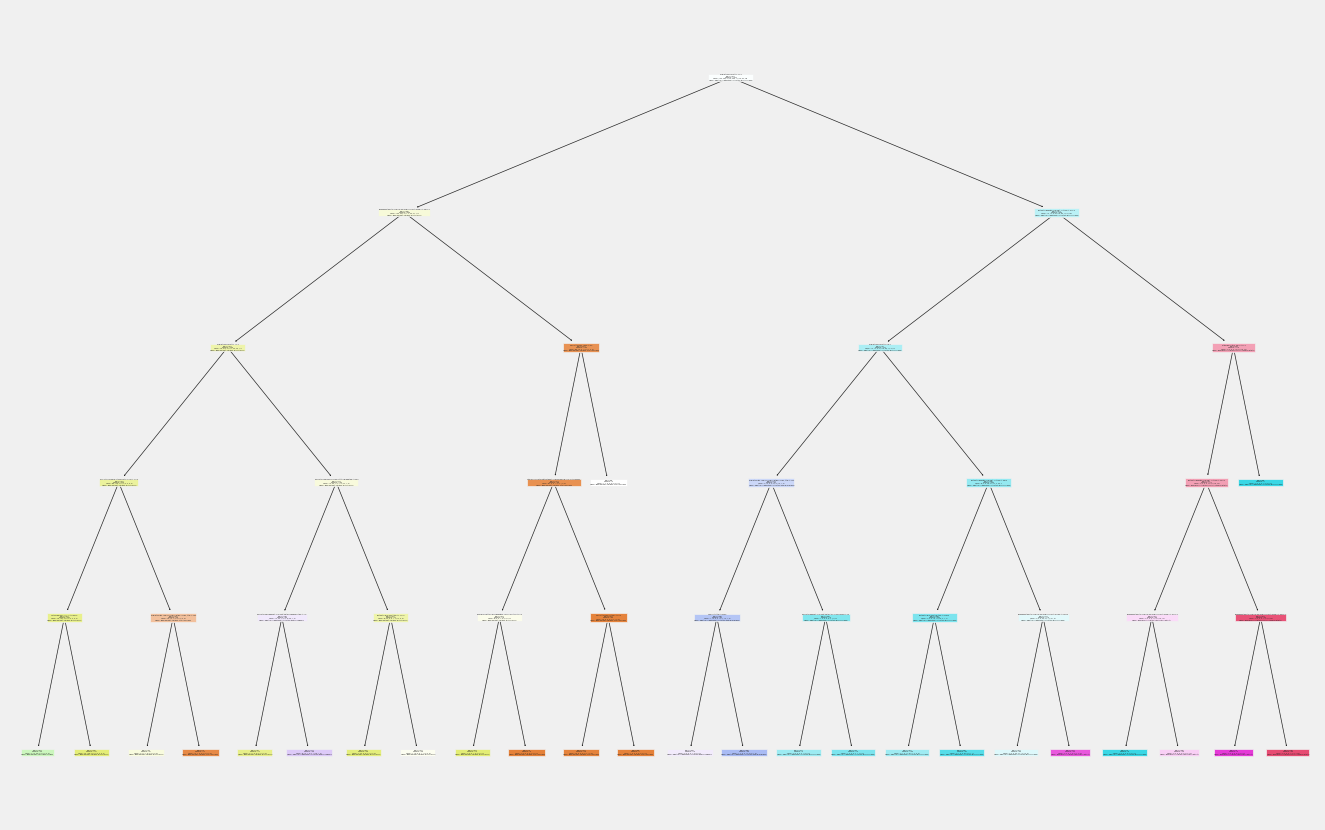

In [65]:
from sklearn.tree import plot_tree

# Plot the final decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_best, filled=True, feature_names=X_train_final.columns.tolist(), class_names=[str(c) for c in le.classes_])
plt.show()


There seems to be no difference in the dt_best model and the original model.

## Step 4: Random Forrest Classifier

## Run the Random Forest Classifier on the preprocessed data using all appropriate predictors with the chosen target variable

In [72]:
# Replace NaN with 0 in 'X_train_final'
X_train_final.fillna(0, inplace=True)

# Replace NaN with 0 in 'X_test_final'
X_test_final.fillna(0, inplace=True)

/var/folders/q_/tlj94ng165zc5l_0x0clcwg00000gn/T/ipykernel_58968/592018697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_final.fillna(0, inplace=True)


In [74]:
# Convert boolean columns to 0/1 in 'X_train_final'
X_train_final = X_train_final.astype(int)

# Convert boolean columns to 0/1 in 'X_test_final'
X_test_final = X_test_final.astype(int)

In [75]:
X_train_final.head()

,Endowment assets (year end) per FTE enrollment (FASB),State abbreviation_Maryland,Full-time enrollment,State abbreviation_Maine,Total enrollment,State abbreviation_Delaware,Geographic region_Mid East DE DC MD NJ NY PA,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of freshmen receiving other federal grant aid,FIPS state code_Missouri,"Sector of institution_Public, 4-year or above",Percent of undergraduate enrollment that are women,Percent of total enrollment that are Nonresident Alien,FIPS state code_Alaska,SAT Critical Reading 25th percentile score,Percent of freshmen receiving state/local grant aid,"Estimated graduate enrollment, total",FIPS state code_Kansas,FIPS state code_Hawaii,Number of first-time undergraduates - out-of-state,"Tuition and fees, 2012-13",Percent of total enrollment that are Hispanic/Latino,Undergraduate enrollment,FIPS state code_New Jersey,"Estimated undergraduate enrollment, full time",Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are women,"Estimated enrollment, part time",State abbreviation_California,"Estimated freshman enrollment, part time",State abbreviation_Pennsylvania,Percent of freshmen receiving Pell grants,"Estimated freshman undergraduate enrollment, total",State abbreviation_West Virginia,State abbreviation_Michigan,Degree of urbanization (Urban-centric locale)_Suburb: Small,ACT Composite 25th percentile score,State abbreviation_Vermont,State abbreviation_Wisconsin,State abbreviation_Oklahoma,Enrolled total,Percent of total enrollment that are Race/ethnicity unknown,State abbreviation_Missouri,State abbreviation_New Jersey,FIPS state code_Nevada,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Degree of urbanization (Urban-centric locale)_Town: Distant,Percent of freshmen submitting ACT scores,FIPS state code_Louisiana,State abbreviation_Nebraska,State abbreviation_South Dakota,State abbreviation_Colorado,FIPS state code_Ohio,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,FIPS state code_Nebraska,FIPS state code_Massachusetts,Geographic region_Great Lakes IL IN MI OH WI,"Percent of freshmen receiving federal, state, local or institutional grant aid","Estimated undergraduate enrollment, part time",Graduate enrollment,Percent of freshmen receiving institutional grant aid,State abbreviation_Montana,FIPS state code_Maryland,FIPS state code_Oklahoma,"Graduation rate - Bachelor degree within 4 years, total",Percent of freshmen receiving other loan aid,State abbreviation_Georgia,State abbreviation_Oregon,FIPS state code_Utah,State abbreviation_Washington,Total price for in-state students living on campus 2013-14,State abbreviation_Florida,FIPS state code_New Hampshire,State abbreviation_South Carolina,FIPS state code_Arkansas,Percent of total enrollment that are Asian,"Tuition and fees, 2011-12",Percent of undergraduate enrollment that are Asian,Percent of total enrollment that are White,FIPS state code_Illinois,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,State abbreviation_Idaho,Percent of undergraduate enrollment that are Hispanic/Latino,FIPS state code_Maine,FIPS state code_Montana,Control of institution_Public,Percent of freshmen submitting SAT scores,Degree of urbanization (Urban-centric locale)_Town: Remote,Percent of graduate enrollment that are Asian,State abbreviation_New York,Percent of first-time undergraduates - residence unknown,State abbreviation_New Mexico,FIPS state code_Wisconsin,Geographic region_New England CT ME MA NH RI VT,FIPS state code_Colorado,Percent of total enrollment that are Black or African American,State abbreviation_North Dakota,"Estimated enrollment, full time",Percent of first-time undergraduates - in-state,...,Number of students receiving an Associate's degree,SAT Writing 25th percentile score,F

## Build the model on training data and evaluate the model on the test dataset

In [76]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the Random Forest Classifier to the training data
rf_classifier.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

In [79]:
# Make predictions on the test set
y_test_pred_rf = rf_classifier.predict(X_test_final)

# Evaluate the accuracy of the Random Forest model
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("Accuracy of Random Forest Classifier:", accuracy_rf)

# Calculate confusion matrix for the test set
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

# Extract True Positives, True Negatives, False Positives, and False Negatives for the test set
#TP_rf, TN_rf, FP_rf, FN_rf = conf_matrix_rf.ravel()

TN_rf = conf_matrix_rf.diagonal()[:-1].sum()
FP_rf = conf_matrix_rf[:-1,-1].sum()
FN_rf = conf_matrix_rf[-1,:-1].sum()
TP_rf = conf_matrix_rf[-1,-1]

# Calculate sensitivity and specificity on the test set
sensitivity_rf = TP_rf / (TP_rf + FN_rf)
specificity_rf = TN_rf / (TN_rf + FP_rf)

print("Sensitivity of Random Forest Classifier:", sensitivity_rf)
print("Specificity of Random Forest Classifier:", specificity_rf)

Accuracy of Random Forest Classifier: 0.6160520607375272
Sensitivity of Random Forest Classifier: 0.8214285714285714
Specificity of Random Forest Classifier: 0.981203007518797


## Explore various hyperparameters including class_weight, n_estimators, and max_depth in building the trees and find the optimal combination

In [ ]:
## Code is commented out due to the long processing time.  The best parameters are stored below.

In [80]:
# Define the parameter grid
#param_grid = {
#    'criterion': ['gini', 'entropy'],
#    'n_estimators': [50, 100, 200],
#    'max_depth': [None, 10, 20, 30],
#    'max_features': ['auto', 'sqrt', 'log2', None]
#}

# Create a Random Forest Classifier
#rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
#grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy')

# Fit the GridSearchCV object to the training data
#grid_search.fit(X_train_final, y_train)

# Get the best parameters from the grid search
#best_params = grid_search.best_params_
#print("Best Parameters:", best_params)

# Get the best model from the grid search
#best_rf_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
#cv_accuracy = cross_val_score(best_rf_model, X_train_final, y_train, cv=10, scoring='accuracy')
#print("Cross-validated Accuracy:", np.mean(cv_accuracy))

/Users/nicksartino/anaconda3/envs/Jupyter/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicksartino/anaconda3/envs/Jupyter/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicksartino/anaconda3/envs/Jupyter/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/nicksartino/anaconda3/envs/Jupyter/lib/python3.11/site-packages/sklearn/base.py", li

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 50}
Cross-validated Accuracy: 0.6448857736240913


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'n_estimators': 50}
Cross-validated Accuracy: 0.6448857736240913

## Fit the final random forest model and name it rf_best

In [150]:
# Select columns with non-object data type
X2 = X.select_dtypes(exclude='object')
y2 = y

In [154]:
# Replace NaN with 0 in 'X2'
X2.fillna(0, inplace=True)

In [173]:
# Create a Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
# Fit the Best Model to the training data
rf_best.fit(X_train_final, y_train)


# Create RepeatedStratifiedKFold with 5 folds and 30 repetitions
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=30, random_state=42)

# Perform cross-validation
cv_accuracy_repeated = cross_val_score(rf_best, X2, y2, cv=cv, scoring='accuracy')

# Print the mean and standard deviation of repeated cross-validated accuracy
print("Repeated Cross-validated Accuracy (Mean):", np.mean(cv_accuracy_repeated))
print("Repeated Cross-validated Accuracy (Std Dev):", np.std(cv_accuracy_repeated))

Repeated Cross-validated Accuracy (Mean): 0.6398334433302818
Repeated Cross-validated Accuracy (Std Dev): 0.023545989564394826


## Explain the level of importance of each predictor on your classification model

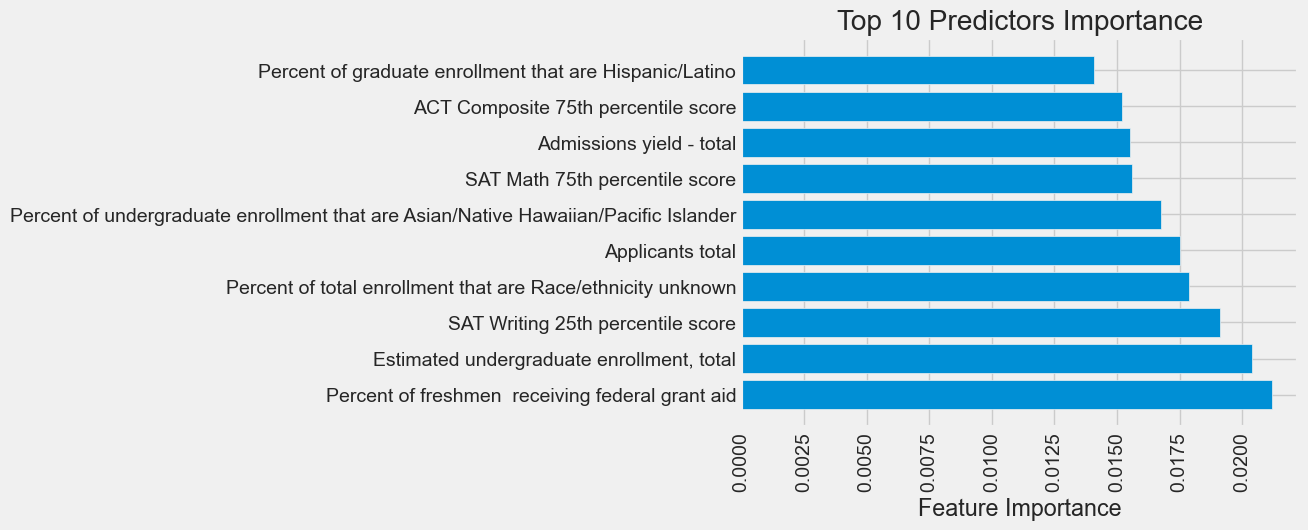

In [175]:
feature_importance = rf_best.feature_importances_
feature_names = X2

top_predictors = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:10]

top_predictor_names, top_predictor_importance = zip(*top_predictors)

plt.barh(top_predictor_names, top_predictor_importance)
plt.xlabel('Feature Importance')
plt.xticks(rotation=90)
plt.title('Top 10 Predictors Importance')
plt.show()

## Explore the various accuracy measures such as Accuracy, Sensitivity, Specificity, and ROC AUC. What do those values mean in terms of your problem?

In [181]:
# Make predictions on the test set
y_test_pred_rf = rf_best.predict(X_test_final)

# Evaluate the accuracy of the Best Forest model
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("Accuracy of Best Forest Classifier:", accuracy_rf)

# Calculate confusion matrix for the test set
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

TN_rf = conf_matrix_rf.diagonal()[:-1].sum()
FP_rf = conf_matrix_rf[:-1,-1].sum()
FN_rf = conf_matrix_rf[-1,:-1].sum()
TP_rf = conf_matrix_rf[-1,-1]

# Calculate sensitivity and specificity on the test set
sensitivity_rf = TP_rf / (TP_rf + FN_rf)
specificity_rf = TN_rf / (TN_rf + FP_rf)

print("Sensitivity of Best Forest Classifier:", sensitivity_rf)
print("Specificity of Best Forest Classifier:", specificity_rf)

Accuracy of Random Forest Classifier: 0.23210412147505424
Sensitivity of Best Forest Classifier: 0.0
Specificity of Best Forest Classifier: 0.981651376146789


In [182]:
print(conf_matrix_rf)

[[ 8 19  1  0 38  2  0  0  0]
 [15 30  0  0 47  0  2  1  0]
 [ 0 11  0  0  7  0  0  0  0]
 [ 2 11  0  0  9  1  0  0  0]
 [19 31  0  0 65  2  0  1  2]
 [ 9 10  0  0 30  3  1  0  0]
 [ 3  4  0  0 14  0  1  0  0]
 [ 6 13  0  0 13  1  0  0  0]
 [10  3  0  0 13  2  1  0  0]]


In [168]:
# Print accuracy for each repetition
for i, acc in enumerate(cv_accuracy_repeated, start=1):
    print(f"Repetition {i}: {acc}")

# Print the mean and standard deviation of repeated cross-validated accuracy
print("\nRepeated Cross-validated Accuracy (Mean):", np.mean(cv_accuracy_repeated))
print("Repeated Cross-validated Accuracy (Std Dev):", np.std(cv_accuracy_repeated))

Repetition 1: 0.6514657980456026
Repetition 2: 0.6416938110749185
Repetition 3: 0.6677524429967426
Repetition 4: 0.6026058631921825
Repetition 5: 0.6666666666666666
Repetition 6: 0.6482084690553745
Repetition 7: 0.6416938110749185
Repetition 8: 0.6123778501628665
Repetition 9: 0.6351791530944625
Repetition 10: 0.6437908496732027
Repetition 11: 0.6221498371335505
Repetition 12: 0.6449511400651465
Repetition 13: 0.6644951140065146
Repetition 14: 0.5960912052117264
Repetition 15: 0.6535947712418301
Repetition 16: 0.5830618892508144
Repetition 17: 0.6384364820846905
Repetition 18: 0.6514657980456026
Repetition 19: 0.6058631921824105
Repetition 20: 0.6568627450980392
Repetition 21: 0.6775244299674267
Repetition 22: 0.6449511400651465
Repetition 23: 0.6547231270358306
Repetition 24: 0.6384364820846905
Repetition 25: 0.6143790849673203
Repetition 26: 0.6286644951140065
Repetition 27: 0.6058631921824105
Repetition 28: 0.6058631921824105
Repetition 29: 0.6514657980456026
Repetition 30: 0.627450

# Step 6: Ridge Regrerssion

In [ ]:
df_focused = df.dropna(subset=['Percent admitted - total'])

# Create A regression model to analyze the admission rate based on factors such as the number of applicants, tuition, average SAT and ACT scores, and other relevant metricds we find.

# Admission rate = total admissions / applicants total

X2 = df_focused.drop('Percent admitted - total',axis=1)
y2 = df_focused['Percent admitted - total']

df_dummies = pd.get_dummies(X2, drop_first=True)
df_dummies.info()

# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)


# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)


# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)



In [ ]:
X_train_rid, X_test_rid, y_train_rid, y_test_rid = train_test_split(df_filtered,y2,test_size=0.3,random_state=21)


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge() 


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit the data i.e calculate the mean and sd of each coluns of X_train
sc.fit(X_train_rid)

#transform the train data
X_train_sc = sc.transform(X_train_rid)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_rid.columns)

#transform the test data
X_test_sc = sc.transform(X_test_rid)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_rid.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the parameter grid for Ridge regression
param_grid = {'alpha': [0.001,0.1, 1, 10, 100,1000, 10000]} 

# Initialize Ridge regression
ridge = Ridge()

# Perform grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train_sc, y_train_rid)

# Find the best lambda (alpha) value
best_alpha = grid_search.best_params_['alpha']

# Train a Ridge model with the best lambda value
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_sc, y_train_rid)


In [ ]:
# Calculate the estimated y values using the test dataset
y_hat_test = best_ridge_model.predict(X_test_sc)

In [ ]:
test_mse = mean_squared_error(y_test_rid, y_hat_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_rid, y_hat_test)
test_r_squared = r2_score(y_test_rid, y_hat_test)
test_mape = mean_absolute_percentage_error(y_test_rid, y_hat_test)

print(f'The test RMSE is:\t{round(test_rmse, 3)}')
print(f'The test Rsquared is:\t{round(test_r_squared, 4)}')
print(f'The test MAPE is:\t{round(test_mape, 4)}')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler


param_grid = {
    'alpha': [0.0000001,0.001,0.1, 1, 10, 100,],
    'kernel': ['poly','laplacian', 'rbf', 'sigmoid'],
    'gamma': [0.0000001, 1,5, 10, 15]  
}

# Standardize your features if needed
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_rid)  # Assuming X_train is your feature matrix

# Initialize Kernel Ridge regression
krr = KernelRidge()

# Perform grid search
grid_search = GridSearchCV(estimator=krr, param_grid=param_grid)
grid_search.fit(X_train_sc, y_train_rid)

# Find the best parameters
best_params = grid_search.best_params_

# Train a Kernel Ridge model with the best parameters
best_krr_model = KernelRidge(**best_params)
best_krr_model.fit(X_train_sc, y_train_rid)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Assuming you have a test dataset X_test and y_test
X_test_sc = scaler.transform(X_test_rid)  # Scale the test features

# Make predictions using the best Kernel Ridge model
y_pred = best_krr_model.predict(X_test_sc)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_rid, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate R-squared (R2)
r2 = r2_score(y_test_rid, y_pred)
print(f"R-squared (R2): {r2}")


cv_scores = cross_val_score(best_krr_model, X_train_sc, y_train_rid, cv=5, scoring='r2')
print("Cross-Validation R-squared scores:", cv_scores)
print(f"Mean Cross-Validation R-squared: {cv_scores.mean()}")
